# Insurance cost prediction using linear regression

We're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


In [1]:
!pip install numpy matplotlib pandas torch torchvision torchaudio

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

The `download_url` is a function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. 

In [5]:
dataframe_raw=pd.read_csv(DATA_FILENAME)
dataframe_raw.head(6)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


For the assignment I'm working on it requires a slight customization of the data so every taker of the course gets a slightly different version of the dataset.

In [6]:
my_name="nehamalcom"

In [7]:
def customize_dataset(dataframe_raw,rand_str):
    dataframe=dataframe_raw.copy(deep=True)
    #drop some rows
    dataframe=dataframe.sample(int(0.95*len(dataframe)),random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe
    

In [8]:
dataframe=customize_dataset(dataframe_raw,my_name)
dataframe.head(10)

,age,sex,bmi,children,smoker,charges
538,46,female,28.33050,1,no,8562.421400
1217,29,male,37.66290,2,no,4220.440744
837,56,female,28.59310,0,no,12124.027656
1082,38,male,20.14950,1,no,6090.138600
563,50,male,45.21770,1,no,9421.079512
1050,44,female,37.32455,1,no,8344.060868
696,53,female,32.62300,2,no,30353.941654
778,35,male,34.66320,3,no,6171.754992
594,41,male,40.66260,0,no,5937.530976
1213,52,female,33.63300,2,no,11239.112560


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
num_rows=len(dataframe)
print(num_rows)

1271


**Q: How many columns does the dataset have**

In [10]:
num_cols=len(dataframe.columns)
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [11]:
input_cols=[title for title in dataframe.columns[:-1]]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

In [12]:
categorical_cols=[title for title in dataframe.select_dtypes(exclude=['number']).columns]
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [13]:
output_cols = [dataframe.columns[-1]]
output_cols

['charges']

**Q: What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**

In [14]:
dataframe['charges'].describe()

count     1271.000000
mean     13763.113577
std      12521.235806
min       1166.748856
25%       4942.447536
50%       9753.020888
75%      17111.433326
max      65096.588014
Name: charges, dtype: float64

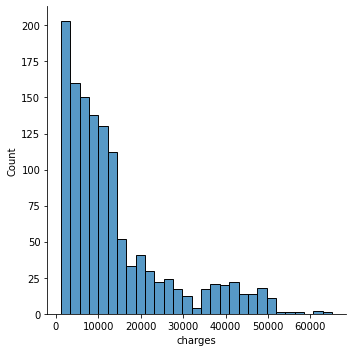

In [15]:
sns.displot(dataframe,x=output_cols[0])

In [16]:
!pip install jovian --upgrade -q

In [17]:
import jovian

In [18]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/nehamalcom/02-insurance-linear-regression


'https://jovian.ai/nehamalcom/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [19]:
def dataframe_to_arrays(dataframe):
    #make a copy of original df
    df1=dataframe.copy(deep=True)
    #convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        df1[col]=df1[col].astype('category').cat.codes
    #extract input and output as numpy arrays
    inputs_array=df1[input_cols].to_numpy()
    targets_array=df1[output_cols].to_numpy()
    return inputs_array,targets_array

In [20]:
inputs_array,targets_array=dataframe_to_arrays(dataframe)
inputs_array,targets_array

(array([[46.     ,  0.     , 28.3305 ,  1.     ,  0.     ],
        [29.     ,  1.     , 37.6629 ,  2.     ,  0.     ],
        [56.     ,  0.     , 28.5931 ,  0.     ,  0.     ],
        ...,
        [46.     ,  0.     , 20.1495 ,  2.     ,  0.     ],
        [63.     ,  1.     , 41.73825,  3.     ,  0.     ],
        [60.     ,  0.     , 28.987  ,  1.     ,  0.     ]]),
 array([[ 8562.4214  ],
        [ 4220.440744],
        [12124.027656],
        ...,
        [ 9561.59204 ],
        [16177.3963  ],
        [13753.68072 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [21]:
inputs=torch.tensor(inputs_array,dtype=torch.float32)
targets=torch.tensor(targets_array,dtype=torch.float32)

In [22]:
inputs.dtype,targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [23]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [24]:
val_percent=0.1873
val_size=int(num_rows*val_percent)
train_size=num_rows-val_size

train_ds,val_ds=random_split(dataset,[train_size,val_size])

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [25]:
batch_size=128

In [26]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [27]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[24.0000,  0.0000, 30.2243,  0.0000,  0.0000],
        [34.0000,  1.0000, 28.1133,  1.0000,  1.0000],
        [44.0000,  1.0000, 30.0324,  2.0000,  0.0000],
        [30.0000,  0.0000, 33.6633,  1.0000,  0.0000],
        [42.0000,  0.0000, 25.2348,  2.0000,  0.0000],
        [63.0000,  0.0000, 36.6630,  0.0000,  0.0000],
        [31.0000,  1.0000, 30.1081,  0.0000,  1.0000],
        [32.0000,  1.0000, 33.9663,  1.0000,  1.0000],
        [29.0000,  0.0000, 28.2194,  1.0000,  1.0000],
        [49.0000,  0.0000, 22.8361,  1.0000,  0.0000],
        [62.0000,  0.0000, 37.2286,  1.0000,  0.0000],
        [36.0000,  0.0000, 22.3563,  3.0000,  0.0000],
        [52.0000,  1.0000, 32.5271,  3.0000,  0.0000],
        [18.0000,  1.0000, 34.7743,  0.0000,  0.0000],
        [54.0000,  1.0000, 31.1080,  1.0000,  1.0000],
        [24.0000,  1.0000, 32.3301,  0.0000,  0.0000],
        [31.0000,  1.0000, 27.9214,  2.0000,  0.0000],
        [19.0000,  0.0000, 32.4311,  0.0000,  0.0000],
  

In [28]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/nehamalcom/02-insurance-linear-regression


'https://jovian.ai/nehamalcom/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 



In [29]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

In [52]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                   # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.mse_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 1000 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [53]:
model=InsuranceModel()

In [54]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2648, -0.1371,  0.3532, -0.3923, -0.0530]], requires_grad=True),
 Parameter containing:
 tensor([-0.3536], requires_grad=True)]

In [55]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ai/nehamalcom/02-insurance-linear-regression


'https://jovian.ai/nehamalcom/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

We will use the fit function.

In [56]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the evaluate function to calculate the loss on the validation set before training.**

In [57]:
result=evaluate(model,val_loader)
print(result)

{'val_loss': 422140928.0}


We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or nan), you may have to re-initialize the model by running the cell model = InsuranceModel(). Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**
Hint: Vary learning rates by orders of 10 (e.g. 1e-2, 1e-3, 1e-4, 1e-5, 1e-6) to figure out what works.

In [58]:
epochs = 1000
lr = 1e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1000], val_loss: 170423520.0000


In [59]:
epochs = 10000
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1000], val_loss: 164340128.0000
Epoch [2000], val_loss: 159109072.0000
Epoch [3000], val_loss: 153090880.0000
Epoch [4000], val_loss: 147632272.0000
Epoch [5000], val_loss: 142739808.0000
Epoch [6000], val_loss: 137318272.0000
Epoch [7000], val_loss: 133077528.0000
Epoch [8000], val_loss: 129857504.0000
Epoch [9000], val_loss: 124457280.0000
Epoch [10000], val_loss: 121629264.0000


In [60]:
epochs = 30000
lr = 1e-5
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1000], val_loss: 117882600.0000
Epoch [2000], val_loss: 113859984.0000
Epoch [3000], val_loss: 111467752.0000
Epoch [4000], val_loss: 107975952.0000
Epoch [5000], val_loss: 105985616.0000
Epoch [6000], val_loss: 101959056.0000
Epoch [7000], val_loss: 99859824.0000
Epoch [8000], val_loss: 96522160.0000
Epoch [9000], val_loss: 94483944.0000
Epoch [10000], val_loss: 92095896.0000
Epoch [11000], val_loss: 89826152.0000
Epoch [12000], val_loss: 87932632.0000
Epoch [13000], val_loss: 85608504.0000
Epoch [14000], val_loss: 83874488.0000
Epoch [15000], val_loss: 81976784.0000
Epoch [16000], val_loss: 80485008.0000
Epoch [17000], val_loss: 78900560.0000
Epoch [18000], val_loss: 77587216.0000
Epoch [19000], val_loss: 75915968.0000
Epoch [20000], val_loss: 74964880.0000
Epoch [21000], val_loss: 73957280.0000
Epoch [22000], val_loss: 72426088.0000
Epoch [23000], val_loss: 70981344.0000
Epoch [24000], val_loss: 69545920.0000
Epoch [25000], val_loss: 68493048.0000
Epoch [26000], val_loss: 674

In [61]:
epochs = 10000
lr = 1e-6
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1000], val_loss: 63804852.0000
Epoch [2000], val_loss: 63729676.0000
Epoch [3000], val_loss: 63584776.0000
Epoch [4000], val_loss: 63586288.0000
Epoch [5000], val_loss: 63518804.0000
Epoch [6000], val_loss: 63516392.0000
Epoch [7000], val_loss: 63427992.0000
Epoch [8000], val_loss: 63288288.0000
Epoch [9000], val_loss: 63104080.0000
Epoch [10000], val_loss: 63125504.0000


In [62]:
epochs = 10000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [1000], val_loss: 59398336.0000
Epoch [2000], val_loss: 52984364.0000
Epoch [3000], val_loss: 51830504.0000
Epoch [4000], val_loss: 49946668.0000
Epoch [5000], val_loss: 48112276.0000
Epoch [6000], val_loss: 46069256.0000
Epoch [7000], val_loss: 45649952.0000
Epoch [8000], val_loss: 50108884.0000
Epoch [9000], val_loss: 46363008.0000
Epoch [10000], val_loss: 45831336.0000


**Q: What is the final validation loss of your model?**

In [64]:
val_loss = history5[-1]['val_loss']
val_loss

45831336.0

In [65]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [66]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/nehamalcom/02-insurance-linear-regression


'https://jovian.ai/nehamalcom/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model


**Q: Complete the following function definition to make predictions on a single input**

In [68]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [69]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([49.0000,  0.0000, 27.4417,  0.0000,  0.0000])
Target: tensor([8945.3828])
Prediction: tensor([9621.5801])


In [70]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([47.0000,  1.0000, 39.3294,  2.0000,  1.0000])
Target: tensor([45970.7578])
Prediction: tensor([34708.1523])


In [71]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([24.0000,  1.0000, 29.5930,  0.0000,  0.0000])
Target: tensor([2056.9275])
Prediction: tensor([3651.2861])


In [72]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/02-insurance-linear-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/nehamalcom/02-insurance-linear-regression


'https://jovian.ai/nehamalcom/02-insurance-linear-regression'